# RODA data

In [4]:
import pandas as pd

INPUT_DATETIME_FORMAT = "%m/%d/%y %H:%M"
OUTPUT_DATETIME_FORMAT = "%Y-%m-%d %H:%M"

original_df = pd.read_csv("./data_samples/datos_roda.csv")
original_df['date'] = pd.to_datetime(original_df['Fecha Inicio'], format=INPUT_DATETIME_FORMAT).dt.strftime("%Y-%m-%d")

result_df = pd.read_csv("./results/datos_roda_processed.csv")
result_df['date'] = pd.to_datetime(result_df['timestampStart'], format=OUTPUT_DATETIME_FORMAT).dt.strftime("%Y-%m-%d")

## RODA Number of Delivery Routes per Day, per Device

In [5]:
original_df_counts = original_df[['Dispositivo', 'date']].value_counts()
original_df_counts

Dispositivo  date      
Xch1238      2023-02-20    80
             2023-02-25    72
Xch1572      2023-09-23    72
Xch1238      2023-02-19    71
Xch1546      2023-06-02    69
                           ..
             2023-07-21     1
             2023-07-20     1
             2023-07-19     1
             2023-07-18     1
Xch1592      2023-12-11     1
Length: 2892, dtype: int64

As you can see original data has devices with more than 80 delivery routes per day. It means that we have some noise with non valid routes. Lets filter out how many of this devices has this issue.

In [6]:
original_df_counts[original_df_counts>30]

Dispositivo  date      
Xch1238      2023-02-20    80
             2023-02-25    72
Xch1572      2023-09-23    72
Xch1238      2023-02-19    71
Xch1546      2023-06-02    69
                           ..
Xch1572      2023-09-24    33
Xch1566      2023-09-24    32
Xch1431      2023-12-05    32
             2023-12-08    32
             2023-12-02    31
Length: 62, dtype: int64

About 62 entries having this issue. Then lets analyse result file.

In [7]:
result_df_counts = result_df[['gpsID', 'date']].value_counts()
result_df_counts

gpsID    date      
Xch1238  2023-02-17    10
         2023-10-18    10
         2023-02-19     9
         2023-06-05     8
         2023-12-04     8
                       ..
Xch1431  2023-11-03     1
         2023-11-11     1
         2023-11-14     1
         2023-11-19     1
Xch1592  2023-12-09     1
Length: 1347, dtype: int64

As you can see there is not any device that have done more than 10 deliveries per date, which makes more sense.

## Minimum and Maximum Distance Analysis

First I want to remove all routes that I know does not makes sense for a delivery, then I will run the distance distribution.

In [20]:
original_df = original_df[original_df['Distancia']>10] # filter in routes with distance > than 10 meters
original_df = original_df[original_df['Referencia'].notnull()] # only count routes that are asigned to an user.

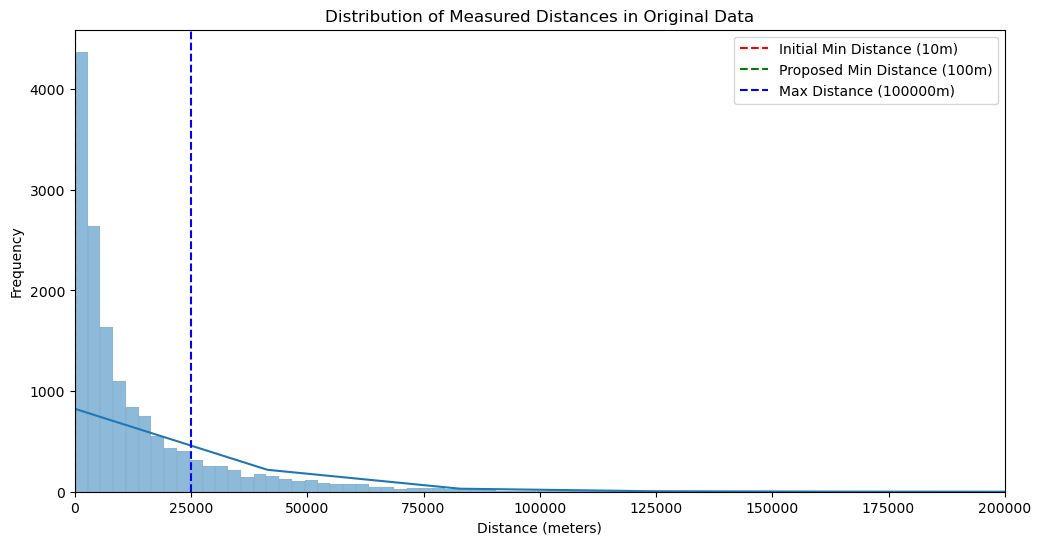

count    1.540300e+04
mean     1.590137e+04
std      1.002571e+05
min      1.057900e+01
25%      2.320680e+03
50%      6.586210e+03
75%      1.763635e+04
max      8.242150e+06
Name: Distancia, dtype: float64


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing the distribution of measured distances
plt.figure(figsize=(12, 6))
sns.histplot(original_df['Distancia'], bins=3000, kde=True)
plt.title('Distribution of Measured Distances in Original Data')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')

# Setting x-axis limits to focus on the area with more routes
# For example, focusing on distances less than 500 meters
plt.xlim(0, 200000)

# initial and proposed thresholds
plt.axvline(10, color='r', linestyle='--', label='Initial Min Distance (10m)')
plt.axvline(100, color='g', linestyle='--', label='Proposed Min Distance (100m)')
plt.axvline(25000, color='b', linestyle='--', label='Max Distance (100000m)')
plt.legend()
plt.show()

# Display basic statistical details of the measured distances
distance_stats = original_df['Distancia'].describe()
print(distance_stats)

As you can see in the original data there are few routes with really big distances, up to 8242km, but it does not makes sense given the dimensions of bogota city. 33km from north to south, and 16km from east to west, aproximately. Given the distribution of data I propose 25km as the maximum rasonable distance for a delivery route. Now lets check out how does it look if we filter it out those big no sense distances:

In [27]:
original_df = original_df[original_df['Distancia']<25000] # filter in routes with distance > than 10 meters

Then lets check how does it looks the distribution

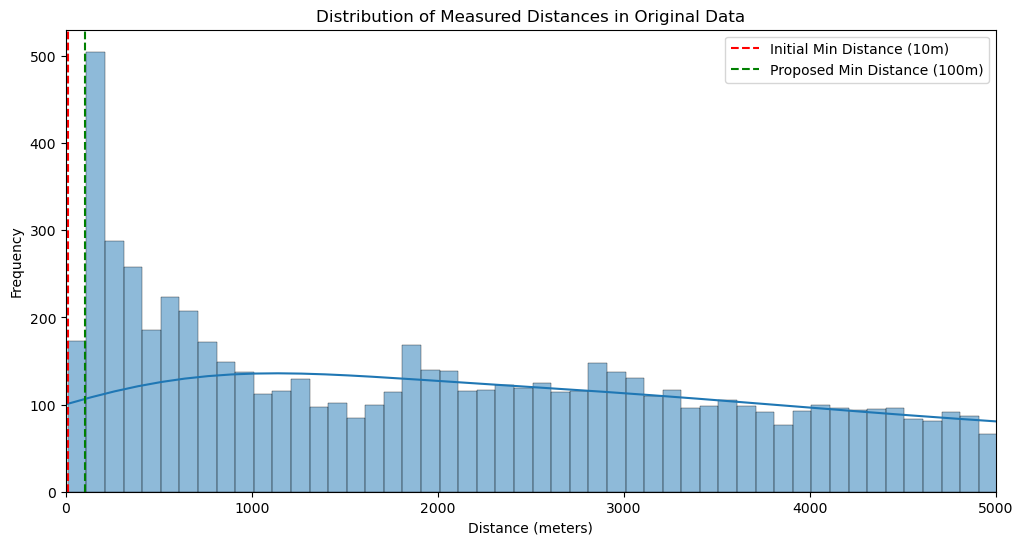

count    12748.000000
mean      6870.225032
std       6400.323893
min         10.579000
25%       1831.820000
50%       4701.945000
75%      10499.225000
max      24996.100000
Name: Distancia, dtype: float64


In [33]:
# Analyzing the distribution of measured distances
plt.figure(figsize=(12, 6))
sns.histplot(original_df['Distancia'], bins=250, kde=True)
plt.title('Distribution of Measured Distances in Original Data')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')

# Setting x-axis limits to focus on the area with more routes
# For example, focusing on distances less than 500 meters
plt.xlim(0, 5000)

# initial and proposed thresholds
plt.axvline(10, color='r', linestyle='--', label='Initial Min Distance (10m)')
plt.axvline(100, color='g', linestyle='--', label='Proposed Min Distance (100m)')
#plt.axvline(25000, color='b', linestyle='--', label='Max Distance (25000m)')
plt.legend()
plt.show()

# Display basic statistical details of the measured distances
distance_stats = original_df['Distancia'].describe()
print(distance_stats)

In [18]:
original_df["Distancia"][(original_df["Distancia"]>10)].describe()

count    1.566600e+04
mean     1.586366e+04
std      9.943207e+04
min      1.057900e+01
25%      2.325725e+03
50%      6.602025e+03
75%      1.766535e+04
max      8.242150e+06
Name: Distancia, dtype: float64

In [10]:
result_df['measuredDistance'].describe()

count    2322.000000
mean      430.705924
std       272.965174
min        10.579000
25%       182.754250
50%       374.058000
75%       649.170750
max       999.906000
Name: measuredDistance, dtype: float64